In [1]:
import numpy as np
import pandas as pd
import polars as pl
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from lets_plot import *
LetsPlot.setup_html()

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("API_KEY")

import mosqlient

In [28]:
# df.filter(pl.col('year')==2020,pl.col('uf')=='CE')['casos'].sum()

In [42]:
df = mosqlient.get_infodengue(
    api_key = api_key,
    disease =  "dengue",
    start_date = "2020-01-01",
    end_date = "2020-12-31",
    uf = 'CE'
)
df['casprov'].sum()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.45requests/s]


In [43]:
# df.columns

24304

In [ ]:
# data['casprov'].sum()

In [7]:
data = pl.read_parquet('../data/dataset_complete_dengue_uf.parquet')
data = data.with_columns(np.log1p(pl.col('casos')).alias('target'))
# data = data.rename({'casos': 'target'})

In [8]:
exo = ['precip_min','precip_max','temp_min','temp_max','pressure_min','pressure_max','population']
train_1 = data.filter(pl.col('train_1'))[['uf','date','target',*exo]]
train_1 = TimeSeriesDataFrame.from_data_frame(train_1.to_pandas(),id_column='uf',timestamp_column='date')
test_1 =  data.filter(
    pl.col('target_1') | (
        # ~pl.col('train_1') & 
        (pl.col('date') < np.max(np.array(data.filter(pl.col('target_1')).sort('date')['date'])))
    )
)[['uf','date','target',*exo]]
test_1 = TimeSeriesDataFrame.from_data_frame(test_1.to_pandas(),id_column='uf',timestamp_column='date')

In [9]:
end_1 = np.array(data.filter(pl.col('train_1')).sort('date')['epiweek'])[-1]
end_2 = np.array(data.filter(pl.col('target_1')).sort('date')['epiweek'])[-1]

# prediction_length = (init_2 - end_1) + test_1.reset_index()[test_1.reset_index()['item_id'] == 'CE'].shape[0]
# prediction_length = end_2 - end_1
prediction_length = 68

In [10]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="target",
).fit(
    train_data=train_1,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
            {"model_path": "bolt_small",
             "covariate_regressor": "CAT",
             "target_scaler": "standard",
             "fine_tune": True,
             "ag_args": {"name_suffix": "FineTuned-Covariates"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
    # presets='fast_training'
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/Users/davibarreira/Documents/DSProjects/Mosqlimate/jbd-mosqlimate-sprint/notebooks/AutogluonModels/ag-20250715_210630'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          0
Memory Avail:       5.03 GB / 16.00 GB (31.4%)
Disk Space Avail:   431.41 GB / 926.35 GB (46.6%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'mode

In [11]:
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosZeroShot[bolt_small],-0.132061,-0.167951,1.586977,1.702112,1.883236,1
1,ChronosFineTuned[bolt_small],-0.137632,-0.173972,0.843683,0.195336,23.163658,2
2,ChronosFineTuned-Covariates[bolt_small],-0.137997,-0.175756,0.779529,0.255072,26.307272,3


In [103]:
predictions = predictor.predict(train_1,model='ChronosFineTuned[bolt_small]')

qs = [str(i) for i in np.sort([float(i) for i in predictions.columns[1:]])]
def check_monotonicity(row, qs):
    return np.all(np.diff(row[qs]) >= 0)

predictions['mono'] = predictions.apply(lambda r: check_monotonicity(r,qs),axis=1)

In [2]:
# predictions[~predictions['mono']]

/var/folders/sz/kh2xcmy51n70hznv18vzsqxr0000gn/T/ipykernel_16502/4075204385.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ufs = pd.unique(data['uf'])
data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.


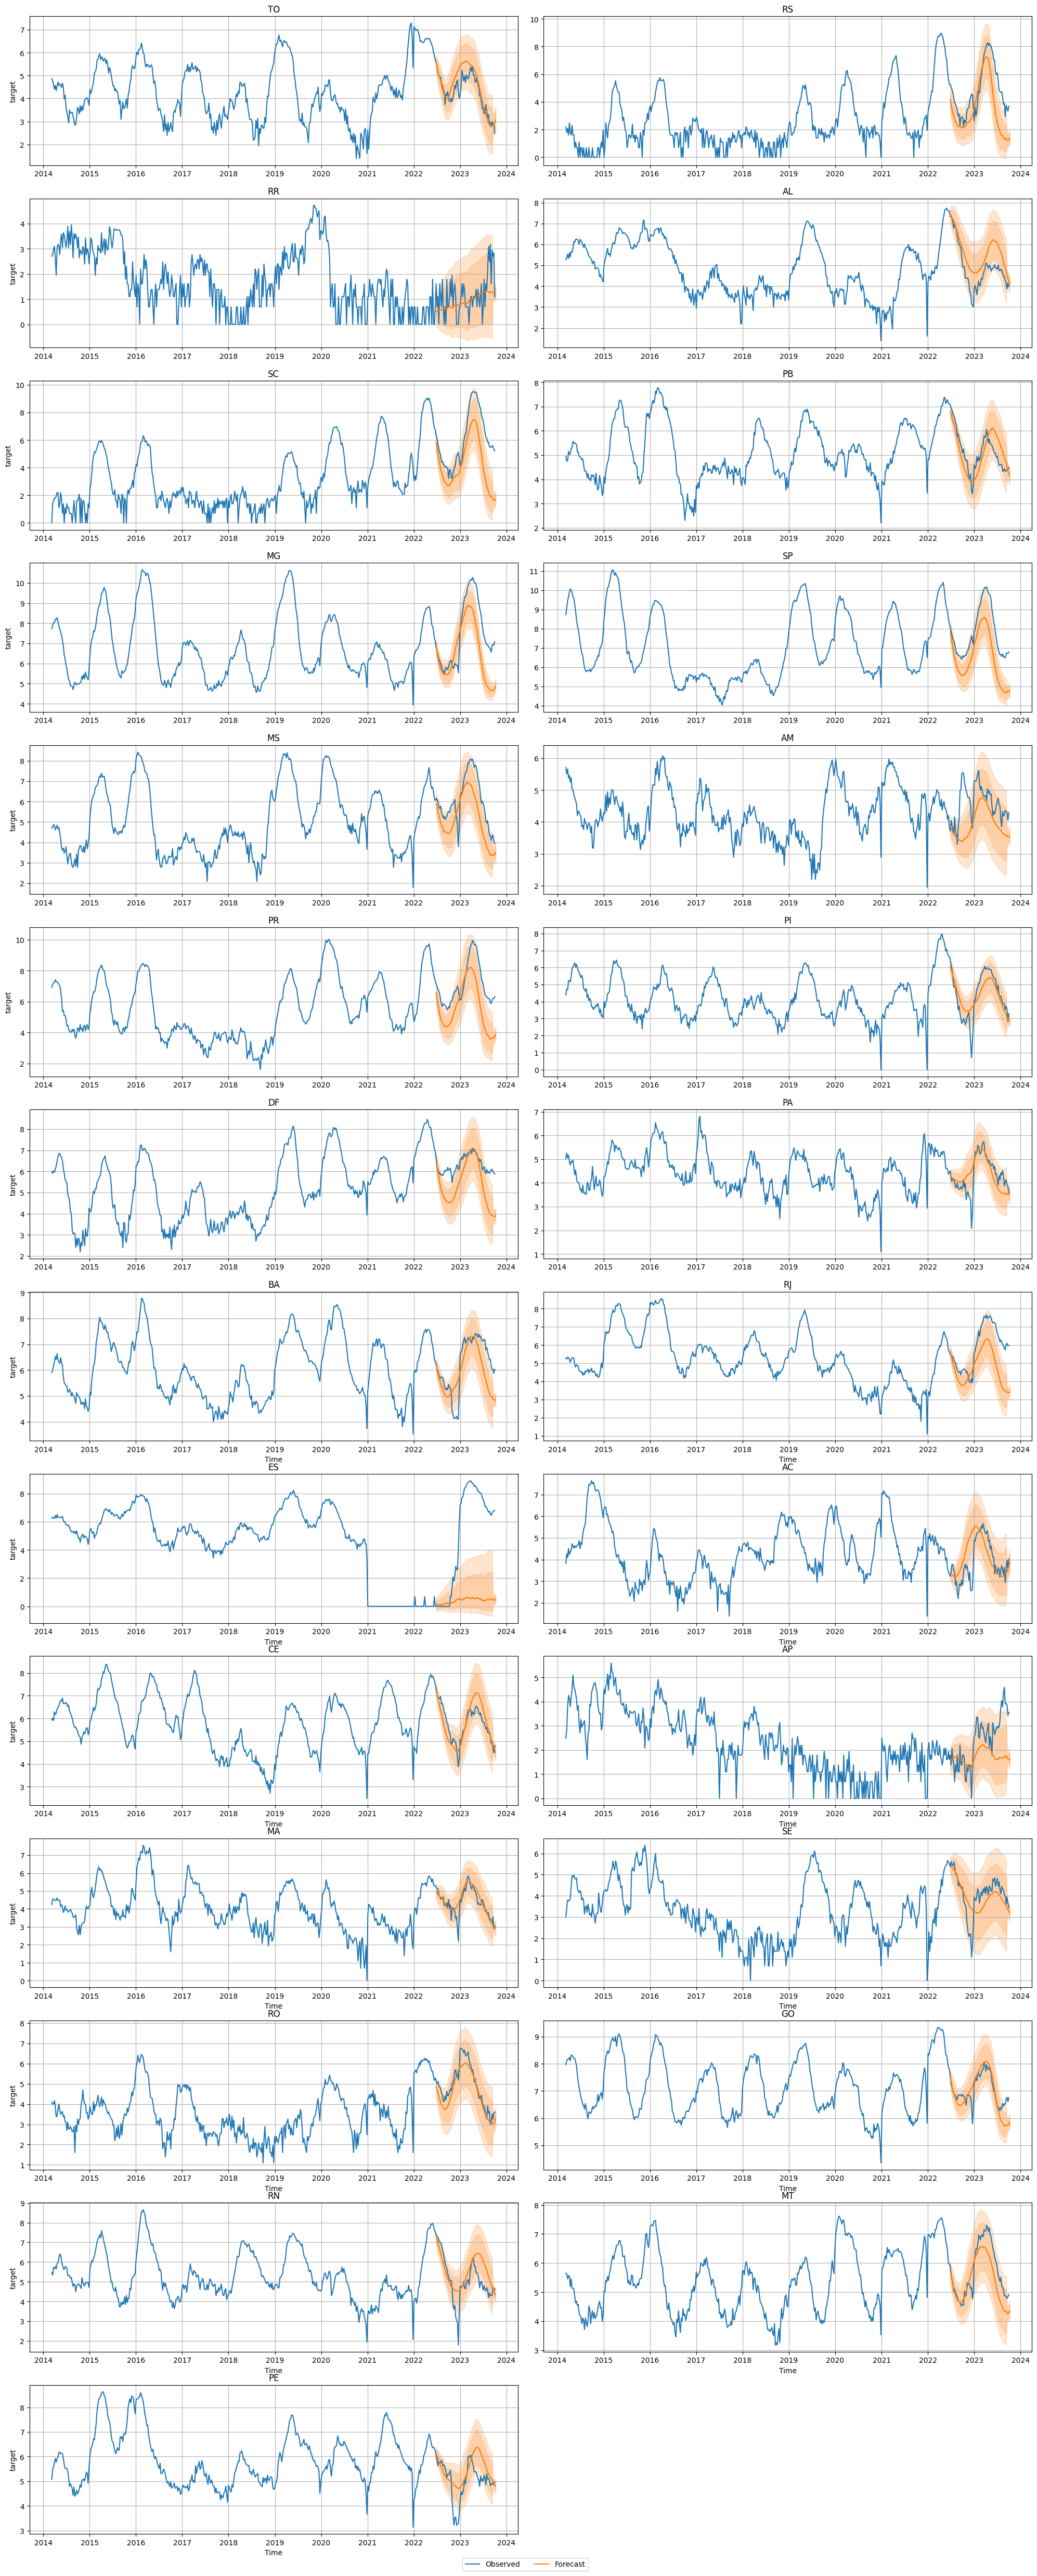

In [105]:
ufs = pd.unique(data['uf'])
predictor.plot(
    data=pd.concat([train_1,test_1]),
    quantile_levels=[0.1,0.2,0.5,0.8,0.9],
    predictions=predictions,
    item_ids = ufs,
    max_num_item_ids=None,
    max_history_length=500,
)

In [106]:
intervals = [0.5,0.8,0.9,0.95]

quantiles = [[np.round(0.5 - i/2,decimals=3), np.round(0.5 + i/2,decimals=3)]for i in intervals]
quantiles

[[0.25, 0.75], [0.1, 0.9], [0.05, 0.95], [0.025, 0.975]]

In [107]:
def estimate_quantile(predictions,target_quantile):
    quantile_values = np.arange(0.1,1.0, 0.1)
    if target_quantile in quantile_values:
        return predictions[str(target_quantile)]
    if target_quantile < 0.1:
        return predictions['0.1'] - (0.1 - target_quantile)*(predictions['0.2'] - predictions['0.1'])/0.1
    if target_quantile > 0.9:
        return predictions['0.9'] + (target_quantile - 0.9)*(predictions['0.9'] - predictions['0.8'])/0.1

    lower_bound = np.round(max(q for q in quantile_values if q < target_quantile),decimals=2)
    upper_bound = np.round(min(q for q in quantile_values if q > target_quantile),decimals=2)
    lower_values = predictions[str(lower_bound)]
    upper_values = predictions[str(upper_bound)]
    slope = (upper_values - lower_values) / (upper_bound - lower_bound)
    return lower_values + slope * (target_quantile - lower_bound)

for q in np.hstack(quantiles):
    predictions[str(q)] = predictions.apply(lambda row: estimate_quantile(row, target_quantile=q), axis=1)

In [114]:
pred = predictions.drop(columns=['mono','mean'])
i = 4
sample = pl.DataFrame(
    {'q':pred.iloc[i].index.values.astype(float),

    'y':pred.iloc[i].values,}
)

(
    ggplot(data=sample)
    + geom_line(aes(x='q', y='y'), color='blue')
    + geom_point(aes(x='q', y='y'), color='blue')
)